# Surabaya Tourism Destination Recommendation System

- Nama  : Labiba Adinda Zahwana
- Email : labibaadinda11@gmail.com

# Deskripsi Proyek

Proyek ini bertujuan membangun sistem rekomendasi destinasi wisata di Kota Surabaya yang dapat membantu pengguna dalam menemukan tempat wisata sesuai preferensi dan kebiasaan mereka.
Dataset yang digunakan pada proyek ini diperoleh dari public repository Kaggle yang dapat diakses melalui tautan berikut: [Indonesian Tourism Destination](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination/code?datasetId=1481754&sortBy=voteCount).
<br>
Sistem ini menggunakan dua pendekatan utama:

1. **Content-Based Filtering**
   > Sistem memanfaatkan deskripsi dan kategori wisata untuk memberikan rekomendasi tempat wisata yang mirip secara konten dengan tempat yang sudah disukai pengguna. Proses ini melibatkan praproses teks menggunakan stemming dan penghilangan kata umum (stopword) Bahasa Indonesia, serta representasi fitur menggunakan TF-IDF dan perhitungan similarity cosine antar objek wisata.

2. **Collaborative Filtering dengan Deep Learning**
   > Menggunakan data rating dari pengguna terhadap destinasi wisata, dibuat model neural network dengan embedding untuk user dan tempat wisata guna mempelajari pola interaksi pengguna. Model ini memprediksi rating untuk tempat yang belum dikunjungi pengguna dan merekomendasikan tempat dengan prediksi rating tertinggi secara personal.




## 1. Import Library
Import library atau package yang akan digunakan pada project ini

In [10]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.9 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

import sklearn.feature_extraction.text as text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import linear_kernel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

Penjelasan library yang digunakan :
- pandas, numpy: Manipulasi data.

- matplotlib, seaborn, plotly.express: Visualisasi data.

- sklearn (TF-IDF, cosine similarity): Untuk content-based filtering.

- Sastrawi: Bahasa Indonesia stemmer dan stopword remover (praproses teks).

- tensorflow.keras: Membuat model deep learning untuk collaborative filtering.



## 2. Data Loading

In [12]:
urls = [
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/package_tourism.csv',
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/tourism_rating.csv',
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/tourism_with_id.csv',
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/user.csv'
]

import pandas as pd

dataframes = [pd.read_csv(url) for url in urls]


In [13]:
data_tourism_rating = pd.read_csv(urls[1])
data_tourism_with_id = pd.read_csv(urls[2])
data_user = pd.read_csv(urls[3])

Data diambil dari URL (CSV online di Github Repository saya) ke dalam DataFrame pandas:

- package_tourism.csv: Paket wisata (tidak digunakan langsung di sini).

- tourism_rating.csv: Data rating pengguna ke tempat wisata.

- tourism_with_id.csv: Data tempat wisata dengan ID.

- user.csv: Data pengguna.

## 3. Data Understanding

- Menampilkan sekilas data (head()).

- Memeriksa ukuran data, tipe data, nilai null.

- Mengecek data duplikat dan akan menghapusnya jika ada (penting agar data bersih) ditahapan data preprocessing.



### 3. 1. Tampilkan Sekilas Data

In [14]:
data_tourism_rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [15]:
data_tourism_with_id.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [16]:
data_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


### 3. 2. Periksa Ukuran Data dan Tipe Data

In [17]:
data_tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [18]:
data_tourism_with_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [19]:
data_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


### 3. 3. Periksa Nilai Null

cek null di masing-masing dataframe

In [20]:
data_tourism_rating.isnull().sum().sort_values(ascending=False)

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [21]:
data_tourism_with_id.isnull().sum().sort_values(ascending=False)

,0
Unnamed: 11,437
Time_Minutes,232
Description,0
Place_Name,0
Place_Id,0
City,0
Category,0
Rating,0
Price,0
Coordinate,0


In [22]:
data_user.isnull().sum().sort_values(ascending=False)

,0
User_Id,0
Location,0
Age,0


### 3. 4. Periksa Duplikasi

In [23]:
data_tourism_with_id.duplicated().sum()

np.int64(0)

In [24]:
data_tourism_rating.duplicated().sum()

np.int64(79)

In [25]:
data_user.duplicated().sum()

np.int64(0)

In [26]:
data_tourism_rating.duplicated().sum()

np.int64(79)

### 3. 5. Cek data berdasarkan kategori tempat wisata nya

In [27]:
data_tourism_with_id['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

Insight :
 1. **Duplikasi pada Dataset**

* **`data_tourism_with_id.duplicated().sum()`**
  Hasil dari `duplicated()` menunjukkan bahwa tidak ada duplikasi data pada `data_tourism_with_id`, dengan total 0 baris duplikat. Ini menandakan bahwa data wisata yang tersedia di sini sudah bersih dari entri yang berulang.

* **`data_user.duplicated().sum()`**
  Dataset pengguna juga tidak memiliki duplikasi dengan total 0 baris duplikat, menunjukkan data yang bersih dari pengguna yang tercatat lebih dari sekali.

* **`data_tourism_rating.duplicated().sum()`**
  Di sisi lain, dataset rating wisata (`data_tourism_rating`) menunjukkan adanya 79 duplikasi. Hal ini berarti ada beberapa baris rating yang sama, yang mungkin berasal dari pengguna yang memberikan lebih dari satu rating untuk tempat wisata yang sama. Ini penting untuk dicatat, karena dapat memengaruhi analisis kualitas atau popularitas tempat wisata tersebut. Perlu tindakan untuk mengatasi duplikasi ini, seperti penggabungan rating atau penghapusan entri yang duplikat.
<br>
2. **Data Null pada dataset**

Terdapat null pada data_tourism_with_id dengan kolom :
- Unnamed: 11 sebanyak 437
- Time_Minutes sebanyak 232
nantinya kolom tsb akan di hapus di tahap **data preprocessing** karena tidak digunakan untuk proses lebih lanjutnya.
<br>
3. **Kategori Wisata (Category)**

Berdasarkan output dari `data_tourism_with_id['Category'].unique()`, terdapat enam kategori wisata yang teridentifikasi dalam dataset ini:

* **Budaya**
* **Taman Hiburan**
* **Cagar Alam**
* **Bahari**
* **Pusat Perbelanjaan**
* **Tempat Ibadah**

Ini menunjukkan bahwa data ini mencakup beragam jenis tempat wisata yang berfokus pada aspek budaya, hiburan, alam, dan tempat ibadah.


### 3. 6. Exploratory Data Analysis (EDA)

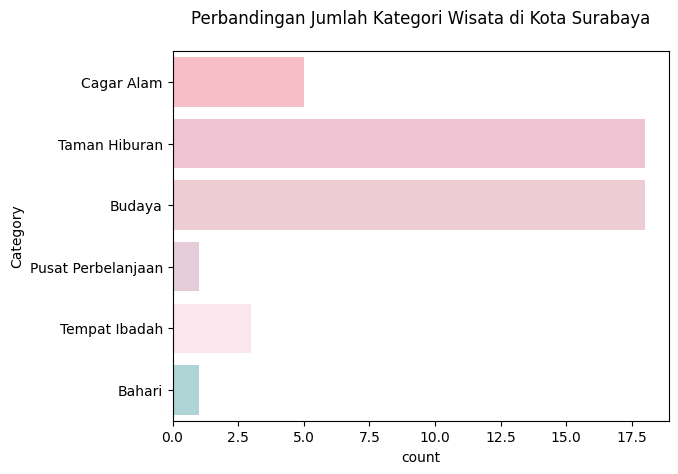

In [28]:
# Membuat visualisasi jumlah kategori wisata di Kota Surabaya
colors = sns.color_palette([
    "#ffb6c1",  # light pink
    "#f8bbd0",  # pastel pink
    "#f3c6d1",  # soft rose
    "#eac7d8",  # dusty pink
    "#fce4ec",  # very light pink
    "#a8dadc",  # pastel blue mint (pelengkap)
    "#ffe5d9",  # pastel peach (pelengkap)
    "#f6d1c1",  # pastel coral (pelengkap)
    "#c1b7a1",  # beige soft (pelengkap)
    "#d9ead3"   # pastel green (pelengkap)
])

sns.countplot(
    y='Category',
    data=data_tourism_with_id[data_tourism_with_id['City'] == 'Surabaya'],
    palette= colors
)

plt.title('Perbandingan Jumlah Kategori Wisata di Kota Surabaya', pad=20)
plt.show()

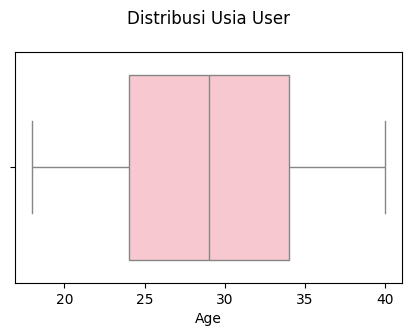

In [29]:
plt.figure(figsize=(5,3))
sns.boxplot(x='Age', data=data_user, color='pink')
plt.title('Distribusi Usia User', pad=20)
plt.show()

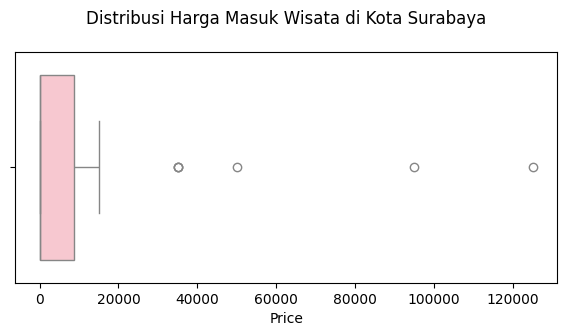

In [30]:
# Membuat visualisasi distribusi harga masuk tempat wisata di surabaya

plt.figure(figsize=(7,3))
sns.boxplot(x=data_tourism_with_id[data_tourism_with_id['City'] == 'Surabaya']['Price'], color='pink')
plt.title('Distribusi Harga Masuk Wisata di Kota Surabaya', pad=20)
plt.show()

Pada EDA ini telah dilakukan :

- Visualisasi kategori wisata yang ada di Surabaya.

- Distribusi usia pengguna.

- Distribusi harga tiket masuk.


Hasil **analisis** EDA :
- jumlah kategori wisata di Kota Surabaya terbanyak yaitu `budaya` dan `taman hiburan`.
- distribusi usia sekitar 23-34 tahun.
- distribusi Harga Masuk Wisata di Kota Surabaya sekitar 0-20000, namun ada beberapa outlier / harga diluar range tsb.


## 4. Data Preparation / Preprocessing

### 4. 1. Data Tourism with ID

#### 4. 1. 1. Menghapus Kolom yang Tidak Relevan atau Mengandung Nilai Null

In [31]:
# Terdapat null pada data_tourism_with_id dengan kolom Unnamed: 11 (sebanyak 437) dan Time_Minutes (sebanyak 232)
# drop kolom yang terdapat null tersebut (Unnamed: 11 dan Time_Minutes)
# dan drop juga kolom yang tidak terpakai
data_tourism_with_id.drop(['Rating','Time_Minutes','Coordinate','Lat','Long','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
data_tourism_with_id

,Place_Id,Place_Name,Description,Category,City,Price
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


#### 4. 1. 2. Filter Data Berdasarkan Kota

Ubah data agar hanya **Kota Surabaya** saja

In [32]:
place = data_tourism_with_id[data_tourism_with_id['City'] == 'Surabaya']

In [33]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price
391,392,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...,Cagar Alam,Surabaya,0
392,393,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0
393,394,Air Mancur Menari,Jembatan Kenjeran dengan air mancur menarinya ...,Taman Hiburan,Surabaya,35000
394,395,Taman Prestasi,Taman Prestasi Surabaya merupakan salah satu t...,Taman Hiburan,Surabaya,0
395,396,Monumen Kapal Selam,"Monumen Kapal Selam, atau disingkat Monkasel, ...",Budaya,Surabaya,15000


data preprocessing pada 4.1 data tourism with id dilakukan **filtering tempat** :
* Drop kolom yang tidak relevan untuk analisis.

* Fokus hanya pada wisata di Kota Surabaya dengan filter City == 'Surabaya'.

### 4. 2. Data Tourism Rating

#### 4. 2. 1. Menghapus Data Duplikat

**menghapus** data tourism rating yang duplikat

In [34]:
data_tourism_rating.drop_duplicates(inplace=True)

In [35]:
# cek kembali apakah data_tourism_rating sudah tidak ada duplicated
data_tourism_rating.duplicated().sum()

np.int64(0)

berhasil drop duplicated di data_tourism_rating

#### 4. 2. 2. Memfilter Data Rating untuk Tempat Wisata di Surabaya

In [36]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Surabaya
rating = pd.merge(data_tourism_rating, place[['Place_Id']], on='Place_Id', how='right')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5


karena data frame kolom **sudah** terfilter untuk Kota Surabaya saja jadi rating disini kan right ya jadi otomatis yang ada di rating tersebut terfilter juga untuk yang berada di kota surabaya saja

In [37]:
# Melihat ukuran dataset rating untuk Kota Surabaya
rating.shape

(1038, 3)

#### 4. 2. 3. Menghitung Rata-Rata Rating per Tempat Wisata

In [38]:
# gabungin antara rating dengan place (yang sudah difilter surabaya aja)
data_rekomendasi = pd.merge(rating.groupby('Place_Id')['Place_Ratings'].mean(),place,on='Place_Id')
data_rekomendasi

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,392,3.312500,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...,Cagar Alam,Surabaya,0
1,393,3.047619,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0
2,394,2.769231,Air Mancur Menari,Jembatan Kenjeran dengan air mancur menarinya ...,Taman Hiburan,Surabaya,35000
3,395,3.304348,Taman Prestasi,Taman Prestasi Surabaya merupakan salah satu t...,Taman Hiburan,Surabaya,0
4,396,3.368421,Monumen Kapal Selam,"Monumen Kapal Selam, atau disingkat Monkasel, ...",Budaya,Surabaya,15000
5,397,3.095238,Taman Kunang-Kunang,Taman Kunang – Kunang di Surabaya ini mempunya...,Taman Hiburan,Surabaya,0
6,398,3.074074,Taman Buah Surabaya,Wisata Taman Buah Undaan di Surabaya adalah sa...,Taman Hiburan,Surabaya,0
7,399,3.588235,Taman Pelangi,Kalau pelangi biasanya ada di siang hari pasca...,Taman Hiburan,Surabaya,0
8,400,2.521739,Hutan Bambu Keputih,Surabaya menjadi kota metropolitan kedua setel...,Cagar Alam,Surabaya,0
9,401,3.576923,Taman Keputran,"Ntah, mengapa nama taman ini disebut dengan ta...",Taman Hiburan,Surabaya,0


Hasil dari kode diatas adalah sebuah dataframe yang berisi:

- Place_Id: ID unik untuk setiap tempat wisata.

- Place_Ratings: Rata-rata rating dari tempat wisata tersebut (setelah dihitung rata-rata per Place_Id).

- Kolom-kolom lain yang ada di dataframe place (misalnya Place_Name, Category, City, dll.) yang memberikan informasi lengkap tentang setiap tempat wisata.

**Pada 4.2. Data tourism rating dilakukan preprocessing dengan cara:**
- Menghapus data tourism rating yang duplikat
- **Memfilter data rating** agar hanya berisi rating dari tempat-tempat wisata yang ada di Surabaya, dengan cara melakukan *merge* antara `data_tourism_rating` dan data `place` (yang sudah difilter hanya tempat wisata di Surabaya) berdasarkan `Place_Id`. Metode penggabungan menggunakan `how='right'` agar hasilnya hanya mencakup tempat wisata Surabaya.

- **Menghitung rata-rata rating** untuk tiap tempat wisata di Surabaya dengan mengelompokkan data rating berdasarkan `Place_Id` dan mengambil nilai rata-rata pada kolom `Place_Ratings`.

- **Menggabungkan hasil rata-rata rating** tersebut kembali dengan data `place` agar memperoleh data lengkap setiap tempat wisata beserta rata-rata ratingnya.


### 4. 3. Data User

In [39]:
data_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


**Memfilter Data Pengguna yang Mengunjungi Wisata di Surabaya**

In [40]:
# Gabungkan dengan data_user untuk hanya mendapatkan user yang mengunjungi wisata di Surabaya
user = pd.merge(data_user, rating[['User_Id']], on='User_Id', how='inner')

# Menampilkan hasil
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,1,"Semarang, Jawa Tengah",20
2,1,"Semarang, Jawa Tengah",20
3,2,"Bekasi, Jawa Barat",21
4,2,"Bekasi, Jawa Barat",21


**Penjelasan** :

1. **Sudah Filter rating untuk Kota Surabaya saja di 4.1 Data tourism rating**:

   * Memilih rating yang hanya terkait dengan tempat wisata yang berada di **Surabaya**. Ini dilakukan dengan memfilter **`data_tourism_with_id`** berdasarkan `City == "Surabaya"` (tahapan ini dilakukan di 4.1) dan memilih `Place_Id` yang terkait dengan tempat wisata di Surabaya.
   * Kemudian, hanya **`User_Id`** yang memiliki **`Place_Id`** tersebut yang hanya akan dimerge.

2. **Gabungkan dengan `data_user`**:

   * **Inner join** antara **`data_user`** dan **`rating`** memastikan hanya **user yang pernah mengunjungi tempat wisata di Surabaya** yang disertakan dalam hasil.

3. **`user.head()`**:

   * Menampilkan 5 baris pertama dari  data yang memastikan hanya pengguna yang pernah memberi rating pada destinasi wisata di Surabaya yang disertakan dalam dataset.

In [41]:
# Melihat dataset user yang pernah memberi rating pada wisata di Surabaya

user.shape

(1038, 3)

Pada tahap preprocessing di data user dilakukan penyaringan data :
> Pada tahap preprocessing di data user, dilakukan penyaringan untuk memfilter data user -> agar hanya mencakup pengguna yang pernah memberi rating pada **destinasi wisata yang terletak di Surabaya**. Hal ini dilakukan dengan menggabungkan data user dengan data rating yang terkait dengan destinasi wisata di Surabaya berdasarkan User_Id.

### 4. 4. Preprocessing Content Based Filtering

**Buat fungsi preprocessing data**

In [42]:
# Fungsi Preprocessing
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

def preprocessing(data):
    data = data.lower()  # Mengubah teks menjadi huruf kecil
    data = stem.stem(data)  # Stemming
    data = stopword.remove(data)  # Menghapus stopwords
    return data

In [43]:
# Salin dataset yang sblmnya sudah di proses yaitu data rekomendasi
# untuk digunakan dalam content-based filtering
data_content_based_filtering = data_rekomendasi.copy()

# Preprocessing kolom 'Description' dan 'Category' untuk menghasilkan 'Tags'
data_content_based_filtering['Description'] = data_content_based_filtering['Description'].apply(preprocessing)
data_content_based_filtering['Category'] = data_content_based_filtering['Category'].apply(preprocessing)

# Menggabungkan 'Description' dan 'Category' menjadi kolom 'Tags'
data_content_based_filtering['Tags'] = data_content_based_filtering['Description'] + " " + data_content_based_filtering['Category']

# Drop kolom yang tidak relevan
data_content_based_filtering.drop(['Price', 'Place_Ratings', 'Description', 'Category', 'City'], axis=1, inplace=True)

data_content_based_filtering

,Place_Id,Place_Name,Tags
0,392,Ekowisata Mangrove Wonorejo,hutan wisata mangrove surabaya rupa wisata gab...
1,393,Taman Harmoni Keputih,tempat sebut ialah taman hatmoni putih surabay...
2,394,Air Mancur Menari,jembatan kenjeran air mancur tar sejati bukan ...
3,395,Taman Prestasi,taman prestasi surabaya rupa salah satu taman ...
4,396,Monumen Kapal Selam,monumen kapal selam singkat monkasel buah muse...
5,397,Taman Kunang-Kunang,taman nang nang surabaya punya luas 400 meter ...
6,398,Taman Buah Surabaya,wisata taman buah unda surabaya salah satu tem...
7,399,Taman Pelangi,kalau pelangi biasa di siang hari pasca hujan ...
8,400,Hutan Bambu Keputih,surabaya jadi kota metropolitan telah jakarta ...
9,401,Taman Keputran,ntah nama taman sebut taman keputran jika kait...


- Untuk keperluan Content-Based Filtering, tiga kolom berikut (Place_Id, Place_Name, dan Tags) sudah cukup untuk melakukan analisis dan memberikan rekomendasi berbasis konten.
- Dengan tiga kolom Place_Id, Place_Name, dan Tags, sudah cukup untuk melakukan Content-Based Filtering berbasis teks menggunakan Cosine Similarity. Kolom tambahan seperti Price atau Place_Ratings tidak diperlukan kecuali ingin memasukkan faktor lain (misalnya, penilaian atau harga) dalam sistem rekomendasi berbasis konten.

Kode ini melakukan **preprocessing data** untuk digunakan nantinya (di tahap modeling) pada sistem rekomendasi berbasis konten dengan:

- Membuat salinan data untuk memastikan eksperimen yang tidak merusak data asli.

- Menggabungkan informasi yang relevan ke dalam kolom baru 'Tags'.

- Menghapus kolom yang tidak diperlukan untuk analisis konten.

Kode diatas bertujuan untuk menyiapkan data yang diperlukan dalam sistem Content-Based Filtering dengan cara:
- Membuat kolom 'Tags' yang menggabungkan deskripsi dan kategori item (tempat wisata).
- Menghapus kolom-kolom yang tidak relevan untuk analisis konten.

**Melakukan Encoding dengan TF-IDF**

In [44]:
# buat variable tf untuk mempermudah pemanggilan method TfidfVectorizer
tv = TfidfVectorizer(max_features=5000)

In [45]:
# Menggunakan TfidfVectorizer untuk mengubah teks menjadi representasi numerik
tfidf_matrix = tv.fit_transform(data_content_based_filtering['Tags']).toarray()
tfidf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Ekstraksi Fitur Teks**
> Menggunakan TF-IDF Vectorizer (Term Frequency - Inverse Document Frequency) yang mengubah teks menjadi representasi numerik berbentuk vektor.
- TF-IDF membantu menimbang kata-kata penting yang membedakan satu tempat wisata dengan yang lain.
- Batasi fitur maksimal (max_features=5000) agar model efisien dan tidak terlalu rumit.

### 4. 5. Preprocessing Collaborative Filtering

In [47]:
data_collaborative_filtering = rating.copy()
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5
...,...,...,...
1033,284,437,5
1034,288,437,1
1035,288,437,4
1036,297,437,4


In [48]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = data_collaborative_filtering['User_Id'].unique().tolist()
print(f'Jumlah user: {len(user_ids)} (ID dari 1 hingga {user_ids[-1]})')

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print(f'user_to_user_encoded: {user_to_user_encoded}')

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print(f'user_encoded_to_user: {user_encoded_to_user}')

Jumlah user: 293 (ID dari 1 hingga 290)
user_to_user_encoded: {25: 0, 44: 1, 108: 2, 119: 3, 125: 4, 132: 5, 133: 6, 135: 7, 151: 8, 179: 9, 182: 10, 224: 11, 232: 12, 251: 13, 297: 14, 298: 15, 1: 16, 6: 17, 8: 18, 19: 19, 27: 20, 59: 21, 69: 22, 73: 23, 82: 24, 104: 25, 120: 26, 131: 27, 137: 28, 174: 29, 180: 30, 184: 31, 255: 32, 261: 33, 271: 34, 43: 35, 65: 36, 83: 37, 97: 38, 99: 39, 149: 40, 154: 41, 159: 42, 188: 43, 210: 44, 217: 45, 267: 46, 286: 47, 5: 48, 35: 49, 46: 50, 49: 51, 79: 52, 106: 53, 129: 54, 178: 55, 193: 56, 209: 57, 216: 58, 220: 59, 237: 60, 256: 61, 262: 62, 14: 63, 37: 64, 41: 65, 68: 66, 121: 67, 128: 68, 155: 69, 175: 70, 176: 71, 203: 72, 226: 73, 230: 74, 235: 75, 265: 76, 272: 77, 28: 78, 29: 79, 31: 80, 40: 81, 74: 82, 140: 83, 202: 84, 258: 85, 268: 86, 276: 87, 287: 88, 291: 89, 300: 90, 13: 91, 17: 92, 23: 93, 53: 94, 58: 95, 85: 96, 102: 97, 160: 98, 166: 99, 170: 100, 190: 101, 191: 102, 196: 103, 198: 104, 257: 105, 259: 106, 285: 107, 18: 108

In [49]:
# Mengubah placeID menjadi list tanpa nilai yang sama
place_ids = data_collaborative_filtering['Place_Id'].unique().tolist()

# Melakukan proses encoding placeID
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# Melakukan proses encoding angka ke placeID
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

In [50]:
# Mapping userID ke dataframe user
data_collaborative_filtering['user'] = data_collaborative_filtering['User_Id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe place
data_collaborative_filtering['place'] = data_collaborative_filtering['Place_Id'].map(place_to_place_encoded)

**Data Interaksi**
> Menggunakan data rating pengguna terhadap destinasi wisata (User_Id, Place_Id, Place_Ratings).
- Rating ini menunjukkan seberapa suka user terhadap suatu tempat.

**Encoding User dan Item**
> User dan tempat wisata diubah dari ID asli menjadi indeks numerik (misal User_Id 101 → indeks 0, dst).
- Ini penting agar bisa dipakai sebagai input embedding pada model neural network.

In [51]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah place
num_place = len(place_encoded_to_place)
print(num_place)

# Mengubah rating menjadi nilai float
data_collaborative_filtering['Place_Ratings'] = data_collaborative_filtering['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(data_collaborative_filtering['Place_Ratings'])

# Nilai maksimal rating
max_rating = max(data_collaborative_filtering['Place_Ratings'])

print('Number of User: {}, Number of place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

293
46
Number of User: 293, Number of place: 46, Min Rating: 1.0, Max Rating: 5.0


In [52]:
data_collaborative_filtering = data_collaborative_filtering.sample(frac=1, random_state=42)
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings,user,place
199,209,401,4.0,57,9
917,32,433,3.0,152,41
536,243,416,5.0,189,24
210,32,402,5.0,152,10
305,17,406,5.0,92,14
...,...,...,...,...,...
87,262,396,3.0,62,4
330,2,407,5.0,199,15
466,208,413,1.0,216,21
121,74,398,3.0,82,6


**Splitting Data**

In [53]:
x = data_collaborative_filtering[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = data_collaborative_filtering['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * data_collaborative_filtering.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 57   9]
 [152  41]
 [189  24]
 ...
 [216  21]
 [ 82   6]
 [ 40  38]] [0.75 0.5  1.   ... 0.   0.5  0.75]


## 5. Model Development

### 5. 1. Content Based Filtering

In [46]:
# Menghitung Cosine Similarity antara setiap pair tempat wisata
similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(similarity[0][1:10])

[0.0696098  0.05875268 0.01923046 0.02888786 0.02165435 0.22933779
 0.02817197 0.15322766 0.03327171]


**Menghitung Similarity**
> Dengan vektor TF-IDF dari semua tempat wisata, dihitung cosine similarity antar tempat wisata.
- Cosine similarity mengukur seberapa mirip dua destinasi berdasarkan konten teksnya, dengan nilai antara 0 (tidak mirip) sampai 1 (sangat mirip).

Content-Based Filtering merekomendasikan item (tempat wisata) berdasarkan kemiripan konten (fitur deskriptif) dari item yang sudah disukai atau pernah dikunjungi oleh pengguna.



In [57]:
# cek kembali data content based filtering yang sudah di preprocessing
data_content_based_filtering

,Place_Id,Place_Name,Tags
0,392,Ekowisata Mangrove Wonorejo,hutan wisata mangrove surabaya rupa wisata gab...
1,393,Taman Harmoni Keputih,tempat sebut ialah taman hatmoni putih surabay...
2,394,Air Mancur Menari,jembatan kenjeran air mancur tar sejati bukan ...
3,395,Taman Prestasi,taman prestasi surabaya rupa salah satu taman ...
4,396,Monumen Kapal Selam,monumen kapal selam singkat monkasel buah muse...
5,397,Taman Kunang-Kunang,taman nang nang surabaya punya luas 400 meter ...
6,398,Taman Buah Surabaya,wisata taman buah unda surabaya salah satu tem...
7,399,Taman Pelangi,kalau pelangi biasa di siang hari pasca hujan ...
8,400,Hutan Bambu Keputih,surabaya jadi kota metropolitan telah jakarta ...
9,401,Taman Keputran,ntah nama taman sebut taman keputran jika kait...


In [55]:
# Menyiapkan fungsi untuk memberikan rekomendasi berdasarkan Content-Based Filtering
def recommend_place_content_based_filtering(place_name, similarity, data_content_based_filtering):
    idx = data_content_based_filtering[data_content_based_filtering['Place_Name'] == place_name].index[0]
    sim_scores = list(enumerate(similarity[idx]))

    # Mengurutkan berdasarkan skor kesamaan (Cosine Similarity)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil 10 rekomendasi teratas
    sim_scores = sim_scores[1:11]  # Menghindari tempat itu sendiri
    place_indices = [i[0] for i in sim_scores]
    return data_content_based_filtering['Place_Name'].iloc[place_indices].reset_index(drop=True)

In [56]:
# Menampilkan rekomendasi untuk 'Taman Bungkul'
print("Rekomendasi untuk 'Taman Bungkul':")
recommend_place_content_based_filtering('Taman Bungkul', similarity, data_content_based_filtering)

Rekomendasi untuk 'Taman Bungkul':


,Place_Name
0,Taman Mundu
1,Taman Flora Bratang Surabaya
2,Taman Barunawati
3,Taman Prestasi
4,Taman Keputran
5,Taman Hiburan Rakyat
6,Taman Buah Surabaya
7,Taman Pelangi
8,Atlantis Land Surabaya
9,Air Mancur Menari


telah **berhasil** membuat rekomendasi berbasis content based filtering

**Kesimpulan dari content based filtering**


> - Hasil Rekomendasi Content-Based Filtering bekerja dengan cara menganalisis kesamaan konten antara destinasi yang dipilih oleh pengguna dan destinasi lain dalam sistem. Ketika pengguna memilih atau menyukai suatu destinasi, sistem akan merekomendasikan destinasi lain yang memiliki nilai **similarity** tinggi dengan destinasi tersebut, berdasarkan **informasi yang ada pada kolom `Tags`**.
- Sistem akan merekomendasikan tempat-tempat yang memiliki **nilai similarity** tinggi di kolom **`Tags`**, yang berisi informasi yang lebih terperinci dan relevan mengenai setiap destinasi.

### 5. 2.  Collaborative Filtering

*Collaborative Filtering* (CF) merekomendasikan item (tempat wisata) kepada pengguna berdasarkan pola interaksi atau preferensi pengguna lain yang serupa. Intinya, “pengguna dengan selera mirip biasanya menyukai tempat yang sama.”

**Modeling**

In [58]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings place
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding place bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [59]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [60]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7185 - root_mean_squared_error: 0.3565 - val_loss: 0.7062 - val_root_mean_squared_error: 0.3663
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6965 - root_mean_squared_error: 0.3484 - val_loss: 0.7043 - val_root_mean_squared_error: 0.3650
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6980 - root_mean_squared_error: 0.3471 - val_loss: 0.7029 - val_root_mean_squared_error: 0.3641
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6874 - root_mean_squared_error: 0.3316 - val_loss: 0.7041 - val_root_mean_squared_error: 0.3648
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6723 - root_mean_squared_error: 0.3355 - val_loss: 0.7041 - val_root_mean_squared_error: 0.3648
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6743 - root_mean_squared_error: 0.3367 - val_loss: 0.7025 - val_root_mean_squared_error: 0.3638
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 

**Model Neural Network dengan Embedding**
- Dibangun model RecommenderNet dengan dua embedding layer: satu untuk user dan satu untuk tempat wisata.
- Embedding ini memetakan user dan tempat ke dalam ruang vektor berdimensi rendah yang merepresentasikan karakteristik dan preferensi.
- Model mempelajari interaksi antara user dan tempat melalui operasi dot product dari embedding yang dipelajari.

**Training Model**
- Model dilatih memprediksi rating pengguna pada tempat wisata tertentu berdasarkan embedding.
- Fungsi loss yang dipakai adalah binary crossentropy, dengan metrik evaluasi Root Mean Squared Error (RMSE).

In [61]:
def get_bulk_recommendations(model, user_ids, user_encoder, item_encoder, item_decoder, user_item_df, item_df, top_k=10):
    """
    Fungsi rekomendasi top_k item untuk banyak user sekaligus.

    Args:
    - model: trained keras model (RecommenderNet)
    - user_ids: list/array user_id asli (misal semua user dalam dataset)
    - user_encoder: dict mapping user_id ke encoded index
    - item_encoder: dict mapping item_id ke encoded index
    - item_decoder: dict mapping encoded index ke item_id
    - user_item_df: DataFrame rating dengan kolom ['User_Id','Place_Id','Place_Ratings']
    - item_df: DataFrame item lengkap (nama, id, dll)
    - top_k: jumlah rekomendasi per user

    Returns:
    - dict: {user_id: [list rekomendasi nama item]}
    """

    all_recommendations = {}

    for user_id in user_ids:
        if user_id not in user_encoder:
            all_recommendations[user_id] = []
            continue

        visited = user_item_df[user_item_df['User_Id'] == user_id]['Place_Id'].values
        not_visited = item_df[~item_df['Place_Id'].isin(visited)]['Place_Id']
        not_visited = list(set(not_visited).intersection(set(item_encoder.keys())))

        if len(not_visited) == 0:
            all_recommendations[user_id] = []
            continue

        user_encoded = user_encoder[user_id]
        not_visited_encoded = [[item_encoder[x]] for x in not_visited]

        user_input = np.hstack((np.array([[user_encoded]] * len(not_visited_encoded)), not_visited_encoded))

        preds = model.predict(user_input).flatten()
        top_indices = preds.argsort()[-top_k:][::-1]

        recommended_ids = [not_visited[i] for i in top_indices]
        recommended_names = item_df[item_df['Place_Id'].isin(recommended_ids)]['Place_Name'].values

        all_recommendations[user_id] = recommended_names.tolist()

    return all_recommendations


**Penjelasan Fungsi** :

Fungsi ini untuk memberikan rekomendasi **top-k item** (dalam hal ini destinasi wisata) untuk **banyak pengguna** sekaligus, berdasarkan model rekomendasi yang telah dilatih (`RecommenderNet`). Ini sangat berguna ketika kamu ingin memberikan rekomendasi untuk sejumlah pengguna dalam waktu yang bersamaan.

### Argumen:

* **model**: Model yang telah dilatih (`RecommenderNet`), yang digunakan untuk memprediksi rekomendasi.
* **user\_ids**: Daftar atau array dari `user_id` yang akan diberikan rekomendasi.
* **user\_encoder**: Dictionary yang memetakan `user_id` ke indeks yang dienkode (encoded index).
* **item\_encoder**: Dictionary yang memetakan `item_id` ke indeks yang dienkode (encoded index).
* **item\_decoder**: Dictionary yang memetakan indeks yang dienkode kembali ke `item_id` asli.
* **user\_item\_df**: DataFrame yang berisi informasi rating dari pengguna terhadap destinasi wisata, dengan kolom `['User_Id', 'Place_Id', 'Place_Ratings']`.
* **item\_df**: DataFrame yang berisi informasi lengkap tentang destinasi wisata (misalnya nama, id, dll).
* **top\_k**: Jumlah rekomendasi yang ingin diberikan untuk setiap pengguna (default 10).

Langkah Kerja Fungsi:

1. **Mempersiapkan Data untuk Rekomendasi**:

   * Untuk setiap `user_id` yang diberikan, fungsi ini memeriksa destinasi wisata mana yang sudah pernah dikunjungi oleh pengguna tersebut (terdaftar di `user_item_df`).
   * Kemudian, destinasi wisata yang belum pernah dikunjungi oleh pengguna tersebut dipilih untuk dipertimbangkan sebagai kandidat rekomendasi.
2. **Memprediksi Rating**:

   * Model rekomendasi (`model`) digunakan untuk memprediksi rating untuk destinasi wisata yang belum dikunjungi oleh pengguna tersebut. Input yang diberikan ke model adalah kombinasi antara `user_encoded` dan `not_visited_encoded` untuk setiap destinasi yang belum dikunjungi.
3. **Menyaring dan Mengurutkan Rekomendasi**:

   * Model menghasilkan prediksi rating untuk semua destinasi yang belum dikunjungi, dan kemudian rekomendasi terbaik (top-k) dipilih berdasarkan nilai rating tertinggi.
4. **Mengonversi ID ke Nama**:

   * Setelah mendapatkan ID destinasi wisata yang direkomendasikan, fungsi ini mengonversinya kembali ke nama destinasi dengan menggunakan `item_df` dan memberikan daftar nama destinasi yang direkomendasikan untuk setiap pengguna.


**Kesimpulan**:

Fungsi ini memungkinkan sistem rekomendasi memberikan beberapa rekomendasi destinasi wisata untuk **banyak pengguna** sekaligus berdasarkan model deep learning yang telah dilatih. Ini sangat efisien untuk memberikan rekomendasi personal dengan pendekatan **Collaborative Filtering**.


In [62]:
all_users = data_collaborative_filtering['User_Id'].unique()

bulk_rekom = get_bulk_recommendations(
    model=model,
    user_ids=all_users,
    user_encoder=user_to_user_encoded,
    item_encoder=place_to_place_encoded,
    item_decoder=place_encoded_to_place,
    user_item_df=data_collaborative_filtering,
    item_df=data_tourism_with_id,
    top_k=10
)

# Contoh print rekomendasi user pertama
first_user = all_users[0]
print('----------------------------------------')
print(f"Rekomendasi untuk user {first_user}:")
print('----------------------------------------')
print(bulk_rekom[first_user])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━

**Penjelasan** :


Kode ini bertujuan untuk memberikan rekomendasi **top-k** tempat wisata untuk **semua pengguna** yang ada dalam dataset, menggunakan model rekomendasi yang sudah dilatih sebelumnya.

Berikut penjelasan langkah demi langkah dari kode tersebut:

1. Mendapatkan Daftar Semua User

Kode pertama mengambil **ID pengguna** yang unik dari dataset, sehingga semua pengguna dalam dataset bisa mendapatkan rekomendasi.

```python
all_users = data_collaborative_filtering['User_Id'].unique()
```

2. Menggunakan Fungsi `get_bulk_recommendations` untuk Rekomendasi untuk Semua Pengguna

Fungsi `get_bulk_recommendations` digunakan untuk memberikan rekomendasi **top-k** item (tempat wisata) untuk **banyak pengguna sekaligus**. Fungsi ini menerima beberapa parameter, seperti model yang sudah dilatih, daftar pengguna (`user_ids`), data interaksi pengguna, dan data tempat wisata. Hasilnya adalah sebuah dictionary dengan `user_id` sebagai key dan daftar rekomendasi sebagai value.

```python
bulk_rekom = get_bulk_recommendations(
    model=model,
    user_ids=all_users,
    user_encoder=user_to_user_encoded,
    item_encoder=place_to_place_encoded,
    item_decoder=place_encoded_to_place,
    user_item_df=data_collaborative_filtering,
    item_df=data_tourism_with_id,
    top_k=10
)
```

3. Menampilkan Rekomendasi untuk User Pertama

Setelah mendapatkan rekomendasi untuk semua pengguna, kode berikut menampilkan rekomendasi untuk pengguna pertama dalam daftar:

```python
first_user = all_users[0]
print(f"Rekomendasi untuk user {first_user}:")
print(bulk_rekom[first_user])
```

Kode ini mengambil rekomendasi untuk pengguna pertama dan menampilkannya. Namun, rekomendasi untuk semua pengguna sudah dihitung dalam fungsi sebelumnya.

Kesimpulan

Fungsi `get_bulk_recommendations` memberikan rekomendasi **top-k** untuk **banyak pengguna sekaligus**. Meskipun **contoh kode untuk yang di print** menampilkan rekomendasi untuk pengguna pertama, fungsi ini sudah menghitung dan mengembalikan rekomendasi untuk semua pengguna dalam dataset. Bisa mengakses rekomendasi untuk pengguna lain dengan cara yang sama, misalnya untuk user kedua `bulk_rekom[all_users[1]]`.


In [63]:
def get_recommendations_for_user(model, user_id, user_encoder, item_encoder, item_decoder, user_item_df, item_df, top_k=10):
    """
    Fungsi untuk rekomendasi top_k item (tempat wisata) untuk user tertentu.

    Args:
    - model: trained keras model (RecommenderNet)
    - user_id: id asli user (misal 'User_Id')
    - user_encoder: dict mapping user_id ke encoded index
    - item_encoder: dict mapping item_id (Place_Id) ke encoded index
    - item_decoder: dict mapping encoded index ke item_id (Place_Id)
    - user_item_df: DataFrame rating dengan kolom ['User_Id','Place_Id','Place_Ratings']
    - item_df: DataFrame item (tempat wisata) lengkap, untuk ambil nama dsb
    - top_k: jumlah rekomendasi yang diinginkan (default=10)

    Returns:
    - List nama item yang direkomendasikan
    """

    if user_id not in user_encoder:
        return f"User ID {user_id} tidak ditemukan dalam data."

    # Tempat yang sudah pernah dikunjungi user
    visited = user_item_df[user_item_df['User_Id'] == user_id]['Place_Id'].values

    # Tempat yang belum dikunjungi
    not_visited = item_df[~item_df['Place_Id'].isin(visited)]['Place_Id']
    not_visited = list(set(not_visited).intersection(set(item_encoder.keys())))

    # Encode user dan tempat yang belum dikunjungi
    user_encoded = user_encoder[user_id]
    not_visited_encoded = [[item_encoder[x]] for x in not_visited]

    # Bentuk array input untuk model
    user_input = np.hstack((np.array([[user_encoded]] * len(not_visited_encoded)), not_visited_encoded))

    # Prediksi rating untuk tempat belum dikunjungi
    preds = model.predict(user_input).flatten()

    # Urutkan indeks rating tertinggi
    top_indices = preds.argsort()[-top_k:][::-1]

    # Decode item_id rekomendasi
    recommended_ids = [not_visited[i] for i in top_indices]

    # Ambil nama tempat dari item_df
    recommended_names = item_df[item_df['Place_Id'].isin(recommended_ids)]['Place_Name'].values

    return recommended_names.tolist()


In [64]:
recommendations = get_recommendations_for_user(
    model=model,
    user_id=123,
    user_encoder=user_to_user_encoded,
    item_encoder=place_to_place_encoded,
    item_decoder=place_encoded_to_place,
    user_item_df=data_collaborative_filtering,
    item_df=data_tourism_with_id,
    top_k=10
)
print('-----------------------------------------------------')
print("Tempat Top 10 Rekomendasi untuk user dengan ID 123:")
print('-----------------------------------------------------')
for place in recommendations:
    print(place)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-----------------------------------------------------
Tempat Top 10 Rekomendasi untuk user dengan ID 123:
-----------------------------------------------------
Taman Prestasi
Monumen Kapal Selam
Taman Pelangi
Taman Keputran
Taman Ekspresi Dan Perpustakaan
Rumah Batik
Masjid Nasional Al-Akbar
Keraton Surabaya
Surabaya Museum (Gedung Siola)
Monumen Jalesveva Jayamahe


Fungsi `get_recommendations_for_user` yang ini digunakan untuk memberikan rekomendasi **top-k item (tempat wisata)** untuk **satu pengguna** berdasarkan model deep learning yang sudah dilatih. Fungsi ini menggunakan pendekatan **Collaborative Filtering**, dan berikut adalah penjelasan dari kode tersebut:

Penjelasan Fungsi:

Fungsi ini akan memberikan rekomendasi destinasi wisata yang **belum dikunjungi** oleh pengguna tertentu, dengan mempertimbangkan prediksi rating untuk setiap destinasi yang tersedia.

Argumen:

* **model**: Model Keras yang sudah dilatih (`RecommenderNet`) untuk menghasilkan prediksi rating untuk tempat wisata.
* **user\_id**: ID pengguna yang ingin diberikan rekomendasi (misalnya 'User\_Id').
* **user\_encoder**: Dictionary yang memetakan `user_id` ke encoded index.
* **item\_encoder**: Dictionary yang memetakan `Place_Id` (ID tempat wisata) ke encoded index.
* **item\_decoder**: Dictionary yang memetakan encoded index kembali ke `Place_Id`.
* **user\_item\_df**: DataFrame yang berisi rating pengguna terhadap tempat wisata, dengan kolom `['User_Id','Place_Id','Place_Ratings']`.
* **item\_df**: DataFrame yang berisi informasi lengkap tentang tempat wisata (misalnya nama, ID, dll).
* **top\_k**: Jumlah rekomendasi yang ingin diberikan untuk pengguna (default 10).

Langkah Kerja Fungsi:

1. **Pengecekan User ID**:

   * Fungsi akan memeriksa apakah `user_id` yang diberikan ada dalam `user_encoder`. Jika tidak, akan mengembalikan pesan bahwa `user_id` tidak ditemukan.
2. **Mempersiapkan Data untuk Rekomendasi**:

   * Fungsi ini pertama-tama mengambil semua destinasi yang sudah pernah dikunjungi oleh pengguna dari `user_item_df` dan menentukan destinasi yang belum dikunjungi.
   * Kemudian, destinasi yang belum dikunjungi yang ada dalam data encoder (`item_encoder`) akan dipertimbangkan sebagai kandidat untuk rekomendasi.
3. **Encode Data**:

   * `user_id` dan destinasi yang belum dikunjungi dienkode menjadi bentuk yang bisa diterima oleh model deep learning.
4. **Prediksi Rating**:

   * Fungsi ini memprediksi rating untuk setiap destinasi yang belum dikunjungi oleh pengguna dengan menggunakan model (`model.predict`).
5. **Pilih Rekomendasi Terbaik**:

   * Prediksi rating yang dihasilkan oleh model kemudian diurutkan, dan 10 rekomendasi teratas dipilih berdasarkan rating tertinggi.
6. **Decode dan Ambil Nama Destinasi**:

   * Setelah memperoleh ID destinasi yang direkomendasikan, fungsi ini mendekode ID tersebut kembali ke nama destinasi yang sebenarnya menggunakan `item_df`.



Kesimpulan:

Fungsi ini memberikan cara untuk merekomendasikan **tempat wisata** bagi **satu pengguna** berdasarkan model deep learning yang telah dilatih menggunakan data interaksi pengguna dan destinasi wisata. Ini merupakan implementasi dasar dari **Collaborative Filtering** yang memanfaatkan teknik embedding neural network untuk mendapatkan rekomendasi yang relevan.


## 6. Evaluation

### 6. 1. Evaluation Content Based Filtering

In [65]:
# Mengevaluasi sistem rekomendasi berbasis konten menggunakan Precision dan Recall
def precision_recall_at_k(recommended, true_relevant, k=3):
    recommended_at_k = recommended[:k]  # Ambil k rekomendasi teratas
    relevant_at_k = [place for place in recommended_at_k if place in true_relevant]  # Temukan yang relevan

    precision = len(relevant_at_k) / k  # Hitung Precision
    recall = len(relevant_at_k) / len(true_relevant)  # Hitung Recall

    return precision, recall

# Data relevan yang diketahui (ground truth)
true_relevant = ['Taman Mundu', 'Taman Barunawati']

# Fungsi rekomendasi berbasis konten yang memberikan daftar tempat wisata yang direkomendasikan
# Fungsi `recommend_place_content_based_filtering` sudah dibuat pada tahap sebelumnya yaitu di tahap 5.1 Model Development Content Based Filtering
recommended_places = recommend_place_content_based_filtering('Taman Bungkul', similarity, data_content_based_filtering)

# Hitung Precision dan Recall untuk top 3 rekomendasi
precision, recall = precision_recall_at_k(recommended_places, true_relevant, k=3)

#print
print(recommended_places[:3])
# Output hasil evaluasi
print(f"Precision at 3: {precision}")
print(f"Recall at 3: {recall}")


0                     Taman Mundu
1    Taman Flora Bratang Surabaya
2                Taman Barunawati
Name: Place_Name, dtype: object
Precision at 3: 0.6666666666666666
Recall at 3: 1.0


**`true_relevant`** adalah **daftar tempat wisata yang relevan** atau **benar-benar relevan** dengan preferensi pengguna, yang digunakan sebagai referensi untuk mengevaluasi kualitas dari sistem rekomendasi.

Penjelasan **`true_relevant`**:

* **`true_relevant`** berisi tempat-tempat yang **seharusnya direkomendasikan** oleh sistem untuk pengguna berdasarkan **pengetahuan atau data relevansi yang diketahui**.
* Ini bisa berupa:

  * **Manual Data**: Tempat wisata yang memang relevan berdasarkan keahlian atau preferensi pengguna yang diketahui.
  * **Ground Truth**: Dalam dunia evaluasi sistem rekomendasi, **`true_relevant`** adalah data yang sudah diketahui kebenarannya dan digunakan sebagai standar atau **"ground truth"** untuk mengukur seberapa baik sistem rekomendasi bekerja.

### Tujuan **`true_relevant`** dalam evaluasi:

1. **Evaluasi Precision**:
   Precision mengukur **berapa banyak dari rekomendasi yang diberikan** benar-benar relevan. **`true_relevant`** digunakan untuk mengetahui item mana yang seharusnya ada dalam rekomendasi dan membandingkannya dengan hasil yang diberikan oleh sistem.

2. **Evaluasi Recall**:
   Recall mengukur **berapa banyak item relevan yang ditemukan oleh sistem** dari **semua item relevan yang ada**. Dengan **`true_relevant`**, kita dapat menghitung seberapa banyak item relevan yang sistem temukan.

Contoh:

Misalnya, **`true_relevant`** adalah tempat-tempat yang relevan dengan preferensi pengguna:

```python
true_relevant = ['Taman Mundu', 'Taman Barunawati']
```

Kemudian, sistem memberikan **rekomendasi** berikut:

```python
recommended_places = ['Taman Mundu','Taman Flora Bratang Surabaya', 'Taman Barunawati']
```

Dari sini, kita dapat menghitung (karena tadi k=3):

* **Precision**: Mengukur **berapa banyak rekomendasi relevan** yang ditemukan dalam **rekomendasi**.

  * Precision = $\frac{2}{3}$ = **0.6666666666666666** (karena **2 dari 3** rekomendasi relevan).

* **Recall**: Mengukur **berapa banyak item relevan yang ditemukan** dibandingkan dengan **semua item relevan** yang ada dalam **`true_relevant`**.

  * Recall = $\frac{2}{2}$ = **1.0** (karena semua item relevan ditemukan).

Kesimpulan:

**`true_relevant`** adalah kumpulan tempat wisata yang relevan dan benar-benar **seharusnya direkomendasikan** berdasarkan pengetahuan atau data yang sudah ada. **`true_relevant`** digunakan sebagai acuan untuk menghitung **Precision** dan **Recall** agar kita bisa mengevaluasi apakah sistem rekomendasi bekerja dengan baik dalam memberikan **rekomendasi yang relevan**.


### 6. 2. Evaluation Collaborative Filtering

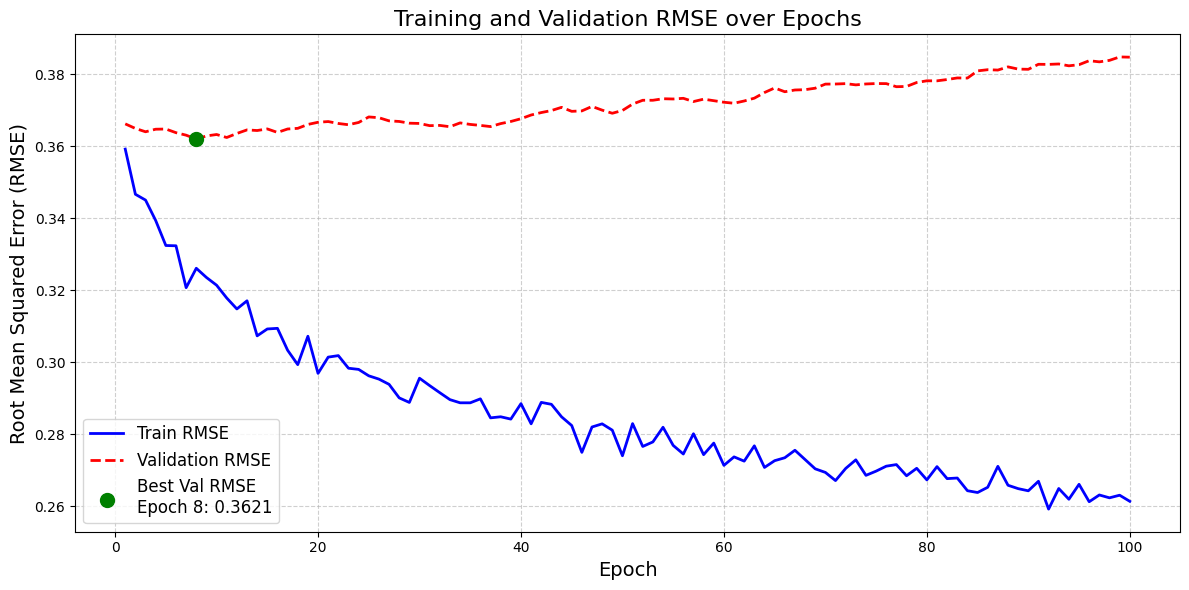

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data RMSE dari history
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse) + 1)

plt.figure(figsize=(12, 6))

# Plot train RMSE
plt.plot(epochs, train_rmse, 'b-', label='Train RMSE', linewidth=2)

# Plot validation RMSE
plt.plot(epochs, val_rmse, 'r--', label='Validation RMSE', linewidth=2)

# Titik terbaik validation RMSE (epoch dengan nilai val RMSE terkecil)
best_epoch = np.argmin(val_rmse) + 1
best_val_rmse = val_rmse[best_epoch - 1]

plt.scatter(best_epoch, best_val_rmse, color='green', s=100, zorder=5,
            label=f'Best Val RMSE\nEpoch {best_epoch}: {best_val_rmse:.4f}')

plt.title('Training and Validation RMSE over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Penjelasan grafik plot :
- Garis biru solid = RMSE training

- Garis merah putus-putus = RMSE validasi

- Titik hijau menandai epoch terbaik berdasarkan validasi RMSE (nilai terendah)

- Plot menunjukkan bahwa nilai RMSE training dan validasi cukup dekat dan stabil, menandakan model tidak overfitting atau underfitting parah.
- `Best Epoch` berdasarkan Val RMSE adalah Epoch ke 17

**Berhasil Membuat Rekomendasi**
- Untuk user tertentu, model memprediksi rating untuk semua tempat yang belum dikunjungi.
- Tempat dengan prediksi rating tertinggi direkomendasikan ke user tersebut.



**Keunggulan Collaborative Filtering**
- Menangkap preferensi tersembunyi dari pola rating banyak pengguna tanpa perlu data atribut item (deskripsi, kategori).
- Dapat memberikan rekomendasi personal yang adaptif mengikuti perilaku dan selera pengguna.
- Bisa merekomendasikan item yang berbeda jauh dari yang sudah pernah user lihat (eksplorasi).

**Keterbatasan**
- Membutuhkan data interaksi (rating) yang cukup banyak agar model efektif.
- Cold start problem untuk user atau item baru yang belum punya data rating.
- Model perlu pelatihan ulang jika data rating baru masuk.

## 7. Conclusion

Sistem **Rekomendasi Destinasi Wisata Surabaya** berhasil dikembangkan dengan menggabungkan dua pendekatan utama, yaitu **Content-Based Filtering** dan **Collaborative Filtering** menggunakan deep learning.

Proyek ini dimulai dengan pemahaman data (Data Understanding), yang mencakup analisis data mengenai destinasi wisata, rating pengguna, dan kategori wisata di Surabaya. Melalui Exploratory Data Analysis (EDA), diperoleh wawasan penting, seperti tempat wisata yang paling banyak dikunjungi dan distribusi kategori wisata di kota tersebut. Selanjutnya, pada tahap data preprocessing, kami membersihkan dan memfilter data untuk memastikan kualitasnya. Fokus utama pada tahap ini adalah menangani nilai yang hilang, menghapus duplikasi, dan memfilter data yang relevan untuk destinasi wisata di Surabaya.

Setelah data siap, sistem rekomendasi ini dibangun dengan mengombinasikan dua pendekatan utama yang dapat memberikan hasil rekomendasi yang lebih akurat dan relevan untuk pengguna, yaitu **Content-Based Filtering** dan **Collaborative Filtering**. Kedua pendekatan ini memiliki kelebihan masing-masing dalam memberikan rekomendasi berdasarkan karakteristik destinasi atau pola interaksi antar pengguna.

1. **Content-Based Filtering** diimplementasikan dengan menganalisis data teks, seperti deskripsi dan kategori tempat wisata. Pendekatan ini menggunakan **TF-IDF** dan **Cosine Similarity** untuk memberikan rekomendasi tempat yang mirip dengan yang sudah disukai atau dikunjungi pengguna. Hal ini membantu pengguna menemukan tempat wisata baru yang memiliki karakteristik serupa dengan yang mereka sukai.

2. **Collaborative Filtering**, dengan menggunakan model deep learning dan **embedding neural network**, mampu menangkap pola interaksi yang lebih kompleks antara pengguna dan destinasi wisata. Model ini memprediksi rating untuk tempat wisata yang belum dikunjungi oleh pengguna dan memberikan rekomendasi yang lebih personal, berdasarkan preferensi pengguna yang serupa. Metode ini sangat berguna untuk menyesuaikan dengan perubahan selera pengguna.

Hasil evaluasi menggunakan metrik **Precision** dan **Recall** untuk Content-Based Filtering serta **RMSE** untuk Collaborative Filtering menunjukkan bahwa sistem ini efektif dan dapat diandalkan.

Secara keseluruhan, sistem ini **berhasil** memberikan rekomendasi yang akurat dan relevan untuk memberikan rekomendasi tempat wisata di Surabaya.
